In [ ]:
#Libraries
import pandas as pd
import numpy as np
from collections import defaultdict

#sklearn
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

#Graphviz
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10,5)})
sns.set_style("whitegrid")

#Remove warnings
import warnings
warnings.filterwarnings('ignore')

### Ques 1. Download the data

In [ ]:
# download the file and read_csv i Pandas DataFrame
filename = 'german.data'
names = ['existingchecking', 'duration', 'credithistory', 'purpose', 'creditamount', 
         'savings', 'employmentsince', 'installmentrate', 'statussex', 'otherdebtors', 
         'residencesince', 'property', 'age', 'otherinstallmentplans', 'housing', 
         'existingcredits', 'job', 'peopleliable', 'telephone', 'foreignworker', 'classification']
data = pd.read_csv(filename, delimiter=' ', skiprows=1, names = names)
print(data.shape)
data.head(2)

(999, 21)


,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,classification
0,A12,48,A32,A43,5951,A61,A73,2,A92,A101,...,A121,22,A143,A152,1,A173,1,A191,A201,2
1,A14,12,A34,A46,2096,A61,A74,2,A93,A101,...,A121,49,A143,A152,1,A172,2,A191,A201,1


In [ ]:
#Description
data.describe()

,duration,creditamount,installmentrate,residencesince,age,existingcredits,peopleliable,classification
count,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,999.000000
mean,20.917918,3273.362362,2.971972,2.843844,35.514515,1.406406,1.155155,1.300300
std,12.055619,2823.365811,1.118802,1.103665,11.337487,0.577639,0.362234,0.458618
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,1.000000
25%,12.000000,1368.500000,2.000000,2.000000,27.000000,1.000000,1.000000,1.000000
50%,18.000000,2320.000000,3.000000,3.000000,33.000000,1.000000,1.000000,1.000000
75%,24.000000,3972.500000,4.000000,4.000000,42.000000,2.000000,1.000000,2.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,2.000000


### Data Cleaning
####  Missing Values

In [ ]:
print(data.isnull().sum().sum())

0


#### Outliers

In [ ]:
# Binarize the y output for easier use of e.g. ROC curves -> 0 = 'bad' credit; 1 = 'good' credit
data.classification.replace([1,2], [1,0], inplace=True)
# Print number of 'good' credits (should be 700) and 'bad credits (should be 300)
data.classification.value_counts()

1    699
0    300
Name: classification, dtype: int64

#### Feature Correlation


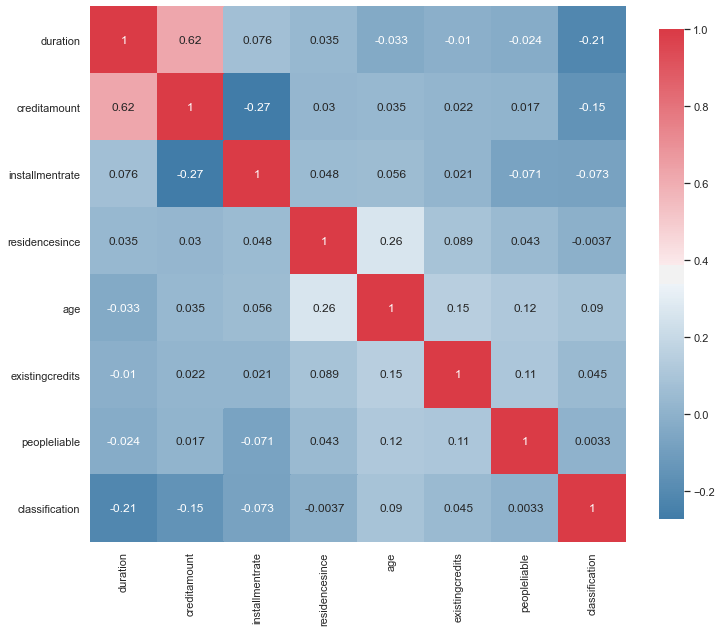

In [ ]:
# feature correlation
def plot_correlation_map( df ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
    _ = sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })
    
plot_correlation_map(data)

### Ques 2. Split Training and Test Data

In [ ]:

X = data.drop('classification', axis=1)
y = data['classification']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.20)
print("Train Data: {0}\nTest Data: {1}".format(X_train.shape,X_test.shape))

Train Data: (799, 20)
Test Data: (200, 20)


### Ques 3a: Would a person with critical credit history, be more credit worthy?

Text(0, 0.5, 'Frequency')

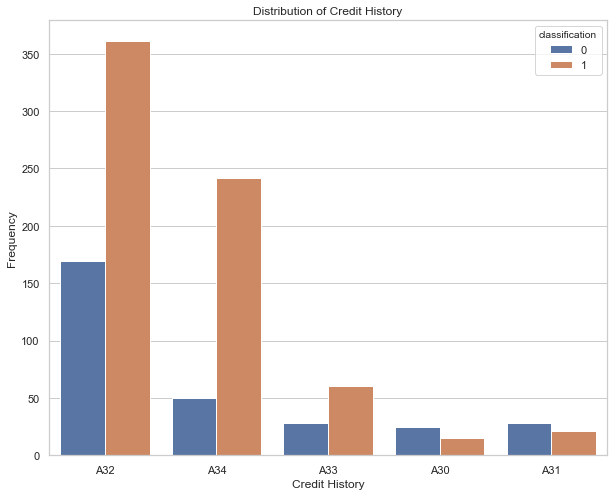

In [ ]:
# Credit history
# A30 : no credits taken/ all credits paid back duly
# A31 : all credits at this bank paid back duly
# A32 : existing credits paid back duly till now
# A33 : delay in paying off in the past
# A34 : critical account/ other credits existing (not at this bank)

plt.figure(figsize=(10,8))
ax = sns.countplot(x="credithistory", data=data,hue='classification')
plt.title('Distribution of Credit History')
plt.xlabel('Credit History')
plt.ylabel('Frequency')

As per the above graph, the critical credit history(A34) shows more worthy people because the frequency is more for good credit people(1) vs bad credit people(0). 

### Ques 3b: Are young people more credit worthy?

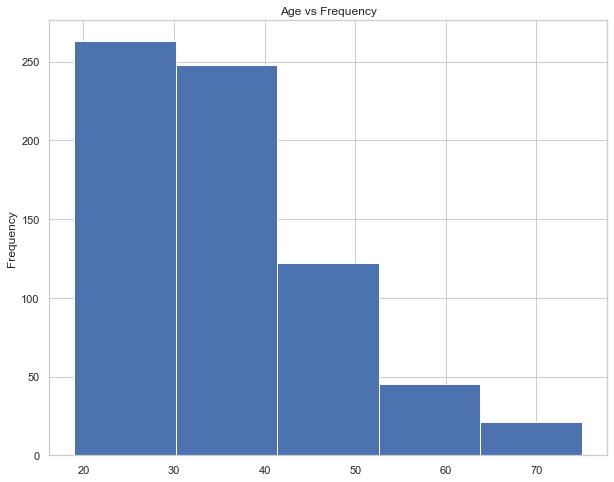

In [ ]:

plt.figure(figsize=(10,8))
plt.title('Age vs Frequency')
plt.hist(data[data.classification==1].age,bins=5)
plt.ylabel('Frequency')
plt.show()


The maximum number of credit worthy people lies between age 20 to age 30 which shows that young people are more credit worthy. 

### Ques 3c : Would a person with more credit accounts, be more credit worthy?

Text(0, 0.5, 'Frequency')

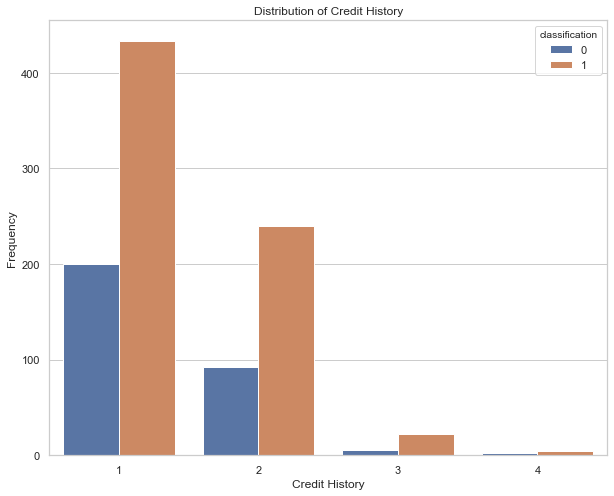

In [ ]:
plt.figure(figsize=(10,8))
ax = sns.countplot(x="existingcredits", data=data,hue='classification')
plt.title('Distribution of Credit History')
plt.xlabel('Credit History')
plt.ylabel('Frequency')

No, more credit accounts doesn't defines the person is credit worthy. As we see in above graph, that least the number of existing credits at this bank more the credit worthy.

In [ ]:
#create quickaccess list with categorical variables labels
catvars = ['existingchecking', 'credithistory', 'purpose', 'savings', 'employmentsince',
           'statussex', 'otherdebtors', 'property', 'otherinstallmentplans', 'housing', 'job', 
           'telephone', 'foreignworker']

#create quickaccess list with numerical variables labels
numvars = ['creditamount', 'duration', 'installmentrate', 'residencesince', 'age', 
           'existingcredits', 'peopleliable']

In [ ]:
#Data Transformation
#Numerical features

# Numerical features range of values
for x in range(len(numvars)):
    print(numvars[x],": ",
          data[numvars[x]].min(),"-",
          data[numvars[x]].max())

creditamount :  250 - 18424
duration :  4 - 72
installmentrate :  1 - 4
residencesince :  1 - 4
age :  19 - 75
existingcredits :  1 - 4
peopleliable :  1 - 2


In [ ]:
#Encoding categorical features
# Labelencoding to transform categorical to numerical
d = defaultdict(LabelEncoder)

# Encoding the variable
train_lecatdata = X_train[catvars].apply(lambda x: d[x.name].fit_transform(x))
test_lecatdata = X_test[catvars].apply(lambda x: d[x.name].transform(x))

# print transformations
for x in range(len(catvars)):
    print(catvars[x],": ", X_train[catvars[x]].unique())
    print(catvars[x],": ", train_lecatdata[catvars[x]].unique())

existingchecking :  ['A14' 'A13' 'A12' 'A11']
existingchecking :  [3 2 1 0]
credithistory :  ['A34' 'A32' 'A31' 'A33' 'A30']
credithistory :  [4 2 1 3 0]
purpose :  ['A43' 'A40' 'A46' 'A41' 'A42' 'A45' 'A44' 'A410' 'A49' 'A48']
purpose :  [4 0 7 1 3 6 5 2 9 8]
savings :  ['A65' 'A61' 'A64' 'A62' 'A63']
savings :  [4 0 3 1 2]
employmentsince :  ['A74' 'A75' 'A73' 'A72' 'A71']
employmentsince :  [3 4 2 1 0]
statussex :  ['A93' 'A92' 'A91' 'A94']
statussex :  [2 1 0 3]
otherdebtors :  ['A101' 'A103' 'A102']
otherdebtors :  [0 2 1]
property :  ['A122' 'A121' 'A124' 'A123']
property :  [1 0 3 2]
otherinstallmentplans :  ['A143' 'A141' 'A142']
otherinstallmentplans :  [2 0 1]
housing :  ['A152' 'A153' 'A151']
housing :  [1 2 0]
job :  ['A173' 'A172' 'A174' 'A171']
job :  [2 1 3 0]
telephone :  ['A191' 'A192']
telephone :  [0 1]
foreignworker :  ['A201' 'A202']
foreignworker :  [0 1]


In [ ]:
#Concat transformed datasets
# append the dummy variable of the initial numerical variables numvars
X_train_clean = pd.concat([X_train[numvars], train_lecatdata], axis = 1)
X_test_clean = pd.concat([X_test[numvars], test_lecatdata], axis = 1)

In [ ]:
# Function for evaluation reports
def get_eval(clf, X_train, y_train,y_test,y_pred):
    # Cross Validation to test and anticipate overfitting problem
    scores1 = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
    scores2 = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
    scores3 = cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc')
    # The mean score and standard deviation of the score estimate
    print("Cross Validation Accuracy: %0.2f (+/- %0.2f)" % (scores1.mean(), scores1.std()))
    print("Cross Validation Precision: %0.2f (+/- %0.2f)" % (scores2.mean(), scores2.std()))
    print("Cross Validation roc_auc: %0.2f (+/- %0.2f)" % (scores3.mean(), scores3.std()))
    # Create and print confusion matrix
    abclf_cm = confusion_matrix(y_test,y_pred)
    print(abclf_cm)
    print('\n')
    return


### Ques 4. Train 3 different prediction algorithms to predict credit worthiness of customers of a German bank.


In [ ]:
# Function to train predictive algorithms 
def train_data(X_train, y_train,X_test,y_test):
    algos = ["LogisticRegression",# Base Algorithm 
             "Decision Tree",
             "RandomForestClassifier"
            ]
    clfs = [
            LogisticRegression(),
            DecisionTreeClassifier(),
            RandomForestClassifier()
           ]

    result = []

    for algo,clf in zip(algos,clfs):
        print(algo)
        clf.fit(X_train,y_train)
        # Predict target variables y for test data
        y_pred = clf.predict(X_test)
        # Get Cross Validation and Confusion matrix
        get_eval(clf, X_train, y_train,y_test,y_pred)
    

### Ques 5. Evaluate models performance

In [ ]:
train_data(X_train_clean,y_train,X_test_clean,y_test) 

LogisticRegression
Cross Validation Accuracy: 0.77 (+/- 0.05)
Cross Validation Precision: 0.80 (+/- 0.04)
Cross Validation roc_auc: 0.78 (+/- 0.05)
[[ 26  32]
 [ 23 119]]


Decision Tree
Cross Validation Accuracy: 0.70 (+/- 0.04)
Cross Validation Precision: 0.80 (+/- 0.04)
Cross Validation roc_auc: 0.64 (+/- 0.06)
[[ 31  27]
 [ 34 108]]


RandomForestClassifier
Cross Validation Accuracy: 0.76 (+/- 0.05)
Cross Validation Precision: 0.79 (+/- 0.03)
Cross Validation roc_auc: 0.80 (+/- 0.05)
[[ 22  36]
 [ 14 128]]




In [ ]:
# Oversampling
# Apply SMOTE
sm = SMOTE()
X_train_clean_res, y_train_res = sm.fit_sample(X_train_clean, y_train)

# Print number of 'good' credits and 'bad credits, should be fairly balanced now
print("Before/After clean")
unique, counts = np.unique(y_train, return_counts=True)
print(dict(zip(unique, counts)))
unique, counts = np.unique(y_train_res, return_counts=True)
print(dict(zip(unique, counts)))


Before/After clean
{0: 242, 1: 557}
{0: 557, 1: 557}


In [ ]:
train_data(X_train_clean_res,y_train_res,X_test_clean,y_test) 

LogisticRegression
Cross Validation Accuracy: 0.77 (+/- 0.07)
Cross Validation Precision: 0.77 (+/- 0.09)
Cross Validation roc_auc: 0.84 (+/- 0.07)
[[ 40  18]
 [ 40 102]]


Decision Tree
Cross Validation Accuracy: 0.76 (+/- 0.10)
Cross Validation Precision: 0.78 (+/- 0.12)
Cross Validation roc_auc: 0.76 (+/- 0.09)
[[ 32  26]
 [ 39 103]]


RandomForestClassifier
Cross Validation Accuracy: 0.84 (+/- 0.09)
Cross Validation Precision: 0.86 (+/- 0.14)
Cross Validation roc_auc: 0.92 (+/- 0.07)
[[ 36  22]
 [ 27 115]]




### 6. Which model would you choose and why?

   Best Algorithm is Random Forest Classifier with a 10-fold Cross-Validation:
        * Cross Validation Accuracy: 0.84 
        * Cross Validation Precision: 0.86 
        * Cross Validation roc_auc: 0.92 

In [ ]:
#Grid Search Cross Validation to get the best parameter for the best estimator i.e. Random Forest 
param_grid = {
            'n_estimators': [50, 100, 200],
            'max_features': [2, 3],
            'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [2, 5, 10]
            }

#define the GridSearch
CV_rnd_cfl = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, cv=10,
                          scoring = 'roc_auc', verbose = 1, n_jobs = -1)
# fit the model
CV_rnd_cfl.fit(X_train_clean_res,y_train_res)

best_parameters = CV_rnd_cfl.best_params_

print("The best parameters: ", best_parameters)

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   25.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   56.6s
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed:  1.2min finished


The best parameters:  {'max_features': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
#From the  Grid Search CV get the best Random Forest parameters 
clf_r = RandomForestClassifier(max_features= best_parameters['max_features'], 
                             min_samples_leaf = best_parameters['min_samples_leaf'],
                              min_samples_split=best_parameters['min_samples_split'],
                              n_estimators = best_parameters['n_estimators'])
# fit the model
clf_r.fit(X_train_clean_res,y_train_res)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=2,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

### Ques 7 : Which are the top 3 features according to the selected model importance?

Text(0.5, 0, 'Feature names')

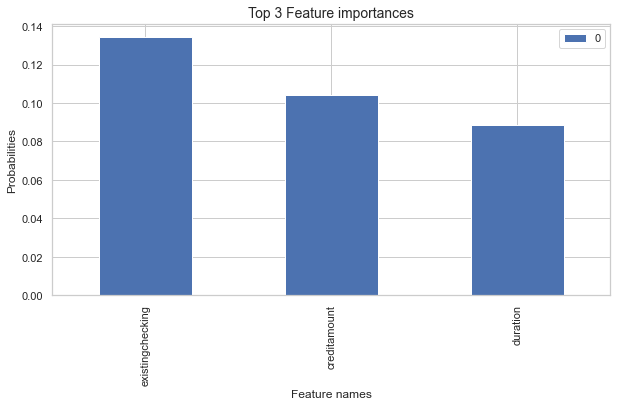

In [ ]:
# Get the feature importance from the Random Forest
feature_imp = pd.DataFrame(clf_r.feature_importances_,index=X_train_clean_res.columns)
feature_imp.sort_values(by = 0 , ascending = False)[:3].plot(kind='bar',align="center")
plt.title("Top 3 Feature importances",fontsize = 14)
plt.ylabel('Probabilities',fontsize = 12)
plt.xlabel('Feature names',fontsize = 12)

In [ ]:
feature_imp.sort_values(by = 0 , ascending = False)[:10]

,0
existingchecking,0.134520
creditamount,0.104323
duration,0.088722
age,0.079236
credithistory,0.067718
savings,0.066561
employmentsince,0.059077
purpose,0.054627
statussex,0.044922
residencesince,0.043273


### Ques 8. Based on the selected model, provide a description of the “best” credit-worthy person.


Random Forest Classifier with oversampling(for imbalance data) gives the best result.

By this we get top 3 features as 

1. existing checking account that allows withdrawals and deposits 
2. credit amount  that the card issuer owes you
3. duration the time to pay the outstanding credit amount

So, the "best" credit-worthy according to above model should have existing checking account and credit amount is paid within the given duration.

In [ ]:
y_pred = clf_r.predict(X_test_clean)
X_test['predicted'] = y_pred
X_test.head()

,existingchecking,duration,credithistory,purpose,creditamount,savings,employmentsince,installmentrate,statussex,otherdebtors,...,property,age,otherinstallmentplans,housing,existingcredits,job,peopleliable,telephone,foreignworker,predicted
922,A12,12,A32,A40,2002,A61,A74,3,A93,A101,...,A122,30,A143,A151,1,A173,2,A192,A201,1
29,A12,18,A32,A49,1913,A64,A72,3,A94,A101,...,A121,36,A141,A152,1,A173,1,A192,A201,1
825,A11,18,A34,A40,3966,A61,A75,1,A92,A101,...,A121,33,A141,A151,3,A173,1,A192,A201,0
755,A13,6,A34,A40,1299,A61,A73,1,A93,A101,...,A121,74,A143,A152,3,A171,2,A191,A202,1
682,A14,24,A34,A43,5103,A61,A72,3,A94,A101,...,A124,47,A143,A153,3,A173,1,A192,A201,1
